# Демонстрация: Промышленный пайплайн обработки больших данных

**Задача:** ETL PubChem (8+ ГБ)в современный, сжатый и высокопроизводительный формат Parquet, готовый для задач машинного обучения.

1.  **Настройка среды:** Установка необходимых серверных утилит и Python-библиотек.
2.  **Конфигурация:** Определение всех путей и констант.
3.  **Извлечение (Extract):** Быстрое и надежное скачивание исходных данных с помощью `aria2c`.
4.  **Преобразование (Transform) и Загрузка (Load):** Эффективная обработка 8 ГБ файла без переполнения памяти с помощью `Dask` и его сохранение в форматы Parquet и CSV для сравнения.
5.  **Анализ и Визуализация:** Наглядное сравнение форматов по занимаемому месту на диске и производительности.

## 1. Настройка среды

In [ ]:
# !poetry add pandas pyarrow datasets requests notebook tqdm psutil matplotlib seaborn "dask[dataframe]"

In [ ]:
# !sudo apt-get update && sudo apt-get install -y aria2

In [1]:
from pathlib import Path
import dask.dataframe as dd
import dask
import time
import pandas as pd
import psutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

## 2. Конфигурация проекта

Определяем все пути в одном месте. Это лучшая практика для обеспечения чистоты и воспроизводимости кода.

In [2]:
# --- Конфигурация путей ---
DATA_DIR = Path("../data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# --- Конфигурация источника данных ---
DATA_URL = "https://drugspacex.simm.ac.cn/static/gz/DrugSpaceX-S-sample-smiles.smi.tar.gz"
ARCHIVE_FILE = DATA_DIR / os.path.basename(DATA_URL)
UNPACKED_FILE = DATA_DIR / ARCHIVE_FILE.name.removesuffix('.tar.gz') 

# --- Конфигурация выходных данных ---
# CSV_PATH = DATA_DIR / "pubchem_full.csv" 
PARQUET_DIR = DATA_DIR / "drugspacex_sample.parquet.dask" 

print("config:")
print(f"  Директория данных: {DATA_DIR.resolve()}")
print(f"  Исходный архив: {ARCHIVE_FILE.name}")
print(f"  Распакованный файл: {UNPACKED_FILE.name}")
# print(f"  Итоговый CSV: {CSV_PATH.name}")
print(f"  Итоговый Parquet: {PARQUET_DIR.name}")

config:
  Директория данных: /app/data
  Исходный архив: DrugSpaceX-S-sample-smiles.smi.tar.gz
  Распакованный файл: DrugSpaceX-S-sample-smiles.smi
  Итоговый Parquet: drugspacex_sample.parquet.dask


## 3. Extract: `aria2c` + `gunzip`

In [6]:
# --- Шаг 1: Скачивание с помощью aria2c ---
command_aria = f'aria2c -c -x 8 -s 8 --dir="{DATA_DIR}" "{DATA_URL}"'
print(f"downloading: {command_aria}\n")
!{command_aria}

# --- Шаг 2: Распаковка с помощью gunzip ---
command_gunzip = f'gunzip -k "{ARCHIVE_FILE}"'
print(f"\nunpack: {command_gunzip}")
if os.path.exists(ARCHIVE_FILE) and not os.path.exists(UNPACKED_FILE):
    !{command_gunzip}
    print("unpacked")
else:
    print("unpacked file exists")

downloading: aria2c -c -x 8 -s 8 --dir="../data" "https://drugspacex.simm.ac.cn/static/gz/DrugSpaceX-Total.smi.tar.gz"


07/09 18:21:11 [NOTICE] Downloading 1 item(s)

07/09 18:21:12 [NOTICE] GID#1717349f07f03fbb - Download has already completed: ../data/DrugSpaceX-Total.smi.tar.gz

07/09 18:21:12 [NOTICE] Download complete: ../data/DrugSpaceX-Total.smi.tar.gz

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
171734|OK  |       0B/s|../data/DrugSpaceX-Total.smi.tar.gz

Status Legend:
(OK):download completed.

unpack: gunzip -k "../data/DrugSpaceX-Total.smi.tar.gz"
gzip: ../data/DrugSpaceX-Total.smi.tar already exists; do you wish to overwrite (y or n)? ^C
unpacked


## 4. Transform & Load

`Dask` lazy multicpu read

In [3]:
# --- Создание Dask DataFrame ---
ddf = dd.read_csv(UNPACKED_FILE, sep='\t')

# --- Более надежная функция для очистки ---
def clean_col_name(name):
    # Приводим к нижнему регистру
    new_name = name.lower()
    # Заменяем пробелы и другие нежелательные символы на _
    new_name = re.sub(r'[\s\(\)-]+', '_', new_name)
    # Удаляем лишние _ в конце, если они появились
    new_name = new_name.strip('_')
    return new_name

# 1. Получаем текущие имена колонок
current_columns = ddf.columns

# 2. Создаем новые, очищенные имена
cleaned_columns = [clean_col_name(col) for col in current_columns]

# 3. Создаем словарь для переименования {старое_имя: новое_имя}
rename_dict = dict(zip(current_columns, cleaned_columns))

# 4. Применяем переименование
ddf = ddf.rename(columns=rename_dict)

print("Колонки после очистки через .rename():")
display(ddf.head())


Колонки после очистки через .rename():


,smiles,de_id,logp,mw,h_a,h_d,r_b,tpas,qed,sascore,parents_id,ns_id,pdb_id,drugbank_id,bindingdb_id,chembl_id,ccdc_id,pains,surechembl_id,novelty
0,O=Cc1ncc(COP(=O)(O)O)c(C=O)c1O,DE2406,0.02,261.00,8,3,5,134.02,0.50,3.35,DE10,NS4,ND,ND,ND,ND,ND,False,ND,1.0
1,CCc1ncc(COP(=O)(O)O)c(C=O)c1O,DE2407,0.77,261.04,7,3,5,116.95,0.53,3.13,DE10,NS15,ND,ND,ND,ND,ND,False,ND,1.0
2,Cc1ncc(COP(=O)(O)O)c(N=O)c1O,DE2408,1.10,248.02,8,3,4,129.31,0.54,3.31,DE10,NS17,ND,ND,ND,ND,ND,False,ND,1.0
3,Cc1ncc(CCP(=O)(O)O)c(C=O)c1O,DE2409,0.63,245.05,6,3,4,107.72,0.53,3.11,DE10,NS40,ND,ND,50336044,CHEMBL3427368,ND,False,ND,1.0
4,Cc1ncc(C(O)OP(=O)(O)O)c(C=O)c1O,DE2410,0.01,263.02,8,4,4,137.18,0.34,3.78,DE10,NS55,ND,ND,ND,ND,ND,False,ND,1.0


In [7]:

# --- Сохранение в Parquet (быстрый шаг) ---
print(f"\nсохранение в Parquet в директорию {PARQUET_DIR.name}...")
start_time_parquet = time.time()
ddf.to_parquet(PARQUET_DIR, engine='pyarrow', compression='snappy', write_index=False, compute=True, overwrite=True)
total_time_parquet = time.time() - start_time_parquet
print(f"Сохранение в Parquet завершено за {total_time_parquet:.2f} сек.")


сохранение в Parquet в директорию drugspacex_sample.parquet.dask...
Сохранение в Parquet завершено за 3.91 сек.


## 5. Анализ и Визуализация №1: Размер на диске

размер CSV принимается за 100%.

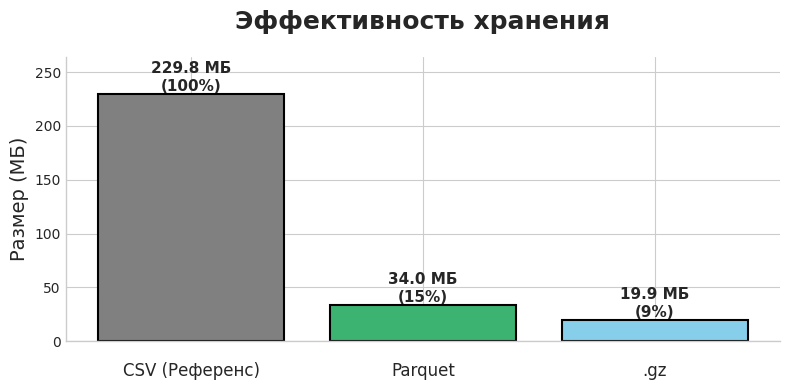

In [5]:
def get_dir_size_mb(path):
    try:
        total = sum(f.stat().st_size for f in Path(path).glob('**/*') if f.is_file())
        return total / (1024 * 1024)
    except FileNotFoundError: return 0

def get_file_size_mb(path):
    try:
        return path.stat().st_size / (1024 * 1024)
    except FileNotFoundError: return 0

packed_size = get_file_size_mb(ARCHIVE_FILE)
unpacked = get_file_size_mb(UNPACKED_FILE)
parquet_total_size = get_dir_size_mb(PARQUET_DIR)

reference_size = unpacked
labels = ['CSV (Референс)', 'Parquet', '.gz']
values = [unpacked, parquet_total_size, packed_size]
percentages = [(v / reference_size) * 100 for v in values]

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 4))
colors = ['grey', 'mediumseagreen', 'skyblue']
bars = ax.bar(labels, values, color=colors, edgecolor='black', linewidth=1.5)

for i, bar in enumerate(bars):
    height = bar.get_height()
    label_text = f'{values[i]:.1f} МБ\n({percentages[i]:.0f}%)'
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, label_text, ha='center', va='bottom', fontsize=11, weight='bold')

ax.set_title('Эффективность хранения', fontsize=18, weight='bold', pad=20)
ax.set_ylabel('Размер (МБ)', fontsize=14)
ax.tick_params(axis='x', which='major', pad=15, labelsize=12)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(values) * 1.15)
plt.tight_layout()
plt.show()

## 6. Анализ и Визуализация №2: Производительность и Память

`Parquet` vs `CSV`

In [11]:
ddf.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 20 entries, smiles to novelty
dtypes: bool(1), float64(6), int64(3), string(10)

In [14]:
len(ddf.smiles)

937230

In [6]:
ddf.columns

Index(['smiles', 'de_id', 'logp', 'mw', 'h_a', 'h_d', 'r_b', 'tpas', 'qed',
       'sascore', 'parents_id', 'ns_id', 'pdb_id', 'drugbank_id',
       'bindingdb_id', 'chembl_id', 'ccdc_id', 'pains', 'surechembl_id',
       'novelty'],
      dtype='object')

In [7]:
# Задача
unique_count_task = ddf['drugbank_id'].nunique()

# Вычисление
unique_count = unique_count_task.compute()
print(unique_count)

492


## 7. Финальные выводы
